# Homework №1 - Data collecting and cleansing

## Data preparing

First of all let's import all the libraries we need

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import requests
import time
from typing import List
from tqdm import tqdm
from tqdm import tqdm_notebook

In [ ]:
data = pd.read_csv('./data_2.csv', sep=',')

In [ ]:
data

Let's check how many gaps we have in the lines, try to fill them

In [ ]:
columns = list(data.columns)

In [ ]:
columns

In the inirial dataframe we have several colums leasted above.
Let's determine what value each parameter has:

1) **DOI (Digital Object Identifier)** - is a string of numbers, letters and symbols used to uniquely identify an article or document, and to provide it with a permanent web address (URL);

2) **Date** - date  of article publication;
3) **Journal** - the name of the journal in which the article was published;

4) **Title** - the title of the article;

5) **Name** - the systematic name, trivial name formula of the chemical compound;

6) **measurement_error** -  is the difference between a measured quantity and its true value;

7) **measurement_wavelength** -  important factor in the determination of refractive index using a spectrophotometer or other optical instrument;

8) **measurement_method** - procedures or techniques used to make these assignments and obtain the numerical or symbolic representation of the properties or characteristics being measured;

9) **normalised_name (SMILES)** - standard notation used in chemistry to represent the structure of molecules and chemical reactions using a short, linear string of characters;

10) **raw_value (reflecting index)** - the measure of bending of a light ray when passing from one medium to another during the experiment;

11) **specifier** - the type of raw_value value.

In [ ]:
print("Missing values distribution by column: ")
print(data.isnull().mean())

Now we can easily look at the distribution of missing values in the given dataset, for example: in the column 'measurement_wavelength' 88,58% of data is missing, in 'normalised_name' - 41,16%, which is sucks actually:( Good news: in columns 'DOI', 'measurement_error', 'measurement_method', 'raw_value' and 'specifier' there are no missing values at all! Cool!

In [ ]:
print("Column datatypes: ")
print(data.dtypes)

Now let's see at the type of data we have. All the columns have object as their datatype aside from 'measurement_error'. In pandas, object means either string or mixed type (numerical and non-numerical type mixed).

Finally, let’s make sure we remove any trailing characters and whitespace using 'strip':

In [ ]:
str_cols = list(data.columns)
str_cols.remove('measurement_error')

In [ ]:
for i in str_cols:
    data[i] = data[i].str.strip()

In [ ]:
data.head()

In [ ]:
missing_by_row = data.isnull().sum(axis=1)
sorted_rows = data.loc[missing_by_row.sort_values(ascending=False).index]
print("Top 10 rows with the most missing values:")
print(sorted_rows.head(10))

Oops, it seems like in some cases in the column 'DOI' the Journal name sticks to the DOI, let's fix it

### Fixing DOI column

Let's have one doi as an example and try to fix it

In [ ]:
print(data.loc[3056, 'DOI'])

Let's also convert the 'DOI' column into a list so it would be more comfy to work with ir

In [ ]:
DOI_column = data['DOI'].tolist()

To separate the DOI from all the other unnecessary stuff we have in this column, let's use a regular expression

In [ ]:
DOI_pattern = re.compile(r'^10\.\d{4,9}\/[-._;()\/:A-Z0-9]+(?=_)')

In [ ]:
DOI_example = '10.1016/S0963-9969(01)00105-3Food Research International'
DOI_example

In [ ]:
DOI_match_example = re.match(DOI_pattern, DOI_example)

In [ ]:
DOI_match_example

Okay, it worked. Now let's try it on the whole column

For that, let's first create a function which will check if the doi valid or not 

In [ ]:
def is_valid_doi(doi_str:str) -> bool:
    """
    Check if a DOI is valid and corresponds to an article on the internet.
    
    Args:
        doi_str (str): A string representing the DOI to be checked.
        
    Returns:
        bool: True if the DOI is valid and corresponds to an article with metadata available on the internet, False otherwise.
        
    Example Usage:
        >>> is_valid_doi('10.1016/j.jacc.2020.02.068')
        True
    """
    # Construct the API URL for the DOI
    url = f"https://api.crossref.org/works/{doi_str}"
    
    # Make an HTTP request to the API
    response = requests.get(url)
    
    # Check if the request was successful
    if response.status_code == 200:
        # Extract the metadata from the response
        metadata = response.json()["message"]
        # Check if the metadata contains a title (i.e., the DOI is valid)
        if "title" in metadata:
            return True
    # If the request failed or the metadata does not contain a title, the DOI is invalid
    return False

Next let's create a function which will clean the DOI column

In [ ]:
def clean_DOI(initial_DOI_list: List[str]) -> List[str]:
    """
    Clean a list of DOIs by removing invalid DOIs and keeping only valid DOIs with metadata available on the internet.

    Args:
        initial_DOI_list (List[str]): A list of strings representing the DOIs to be cleaned.

    Returns:
        List[str]: A list of strings representing the cleaned DOIs. Each element of the returned list is either a valid DOI or the string 'invalid' if the DOI is not valid or does not have metadata available on the internet.

    Example Usage:
        >>> clean_DOI(['10.1016/j.jacc.2020.02.068', '10.3390/bs10010012', '10.1038/nature12373', '10.1162/REST_a_00136'])
        ['10.1016/j.jacc.2020.02.068', '10.3390/bs10010012', 'invalid', 'invalid']
    """
    DOI_pattern = re.compile(r'^10\.\d{4,9}\/[-._;()\/:A-Z0-9]+', flags=re.IGNORECASE)
    cleaned_DOI_list = []
    for DOI in tqdm(initial_DOI_list):
        DOI_match = re.findall(DOI_pattern, DOI)
        if DOI_match:
            DOI_cleaned = DOI_match[0].strip('_')
            if is_valid_doi(DOI_cleaned):
                cleaned_DOI_list.append(DOI_cleaned)
            else:
                cleaned_DOI_list.append('invalid')
        else:
            cleaned_DOI_list.append('invalid')
            print(DOI)
        # Sleep for 0.125 seconds
        time.sleep(0.125)
    return cleaned_DOI_list

In [ ]:
DOI_new = clean_DOI(DOI_column)

In [ ]:
print(len(DOI_column))
print(len(DOI_new))

In [ ]:
DOI_new.count('invalid')

After all, there are still 173 invalid DOI's. Let's try to use another regular expressin on those invalid DOI's

In [ ]:
invalid_ids = [i for i, x in enumerate(DOI_new) if x == 'invalid']
print(invalid_ids)

In [ ]:
invalid_elements = [DOI_column[i] for i in invalid_ids]
print(invalid_elements, invalid_ids)

First of all let's save our dataframe in case something will go wrong

In [ ]:
data.iloc[invalid_ids,:].to_csv("data_2_invalid.tsv", sep='\t')

In [ ]:
pwd

New pattern will make sure the DOI ends up with digit

In [ ]:
DOI_no_invalid_elements = [re.findall(r'^10\.\d{4,9}\/[-._;()\/:A-Z0-9]+\d', invalid_element) for invalid_element in invalid_elements]

In [ ]:
DOI_no_invalid_elements

In [ ]:
status_DOI = [is_valid_doi(DOI_no_invalid_element[0]) for DOI_no_invalid_element in tqdm(DOI_no_invalid_elements) if DOI_no_invalid_element]

In [ ]:
status_DOI

In [ ]:
DOI_pattern_2 = re.compile(r'^10\.\d{4,9}\/[-._;()\/:A-Z0-9]+\d', flags=re.IGNORECASE)

In [ ]:
#DOI_new_backup = DOI_new.copy()

In [ ]:
#with open('DOI_new_backup.txt', 'w') as DOI_file:
    #for DOI in DOI_new_backup:
        #DOI_file.write(DOI+'\n')

In [ ]:
yet_invalid_DOI = {}
for id_x,DOI in tqdm(enumerate(DOI_new)):
    if DOI == 'invalid':
        DOI_to_cor = DOI_column[id_x]
        DOI_pot_cor = re.findall(DOI_pattern_2, DOI_to_cor)
        if len(DOI_pot_cor)>0:
            if is_valid_doi(DOI_pot_cor[0]):
                DOI_new[id_x] = DOI_pot_cor[0]
            else:
                yet_invalid_DOI[id_x]=DOI_to_cor
        else:
            yet_invalid_DOI[id_x]=DOI_to_cor

We have yet still invalid DOI, let's take a look at them

In [ ]:
yet_invalid_DOI

In [ ]:
len(DOI_new)

In [ ]:
DOI_new.count('invalid')

In [ ]:
#DOI_new = DOI_new_backup.copy()

In [ ]:
yet_invalid_DOI = {114: '10.1038/ncomms8',
 136: '10.1016/j.mee.2004.03.068Microelectronic Engineering',
 2057: '10.1016/S0026-2692(03)00137-XMicroelectronics Journal',
 2790: '10.1016/j.snb.2004.06.015',
 3095: '10.1016/S1350-4495(99)00047-XInfrared Physics & Technology',
 3178: '10.3389/fpls.2014.00',
 3555: '10.1002/jbio.201700',
 4420: '10.1016/S0925-4005(99)00427-XSensors and Actuators B: Chemical',
 4500: '10.1063/1.4765',
 4681: '10.1016/S0038-092X(00)00013-XSolar Energy'}

There are only 10 of them, so let's check em and append manually

In [ ]:
DOI_new[114] = 'NA'
DOI_new[136] = '10.1016/j.mee.2004.03.068'
DOI_new[2057] = '10.1016/S0026-2692(03)00137-X'
DOI_new[2790] = '10.1016/j.snb.2004.06.015'
DOI_new[3095] = '10.1016/S1350-4495(99)00047-X'
DOI_new[3178] = 'NA'
DOI_new[3555] = 'NA'
DOI_new[4420] = '10.1016/S0925-4005(99)00427-X'
DOI_new[4500] = 'NA'
DOI_new[4681] = '10.1016/S0038-092X(00)00013-X'

In [ ]:
data['DOI'] = DOI_new

In [ ]:
data.to_csv('data_2_DOI_new.tsv', sep='\t')

## Getting missing values

Let's think on how to collect missing values from columns 'Date', 'Journal', 'Title'. We can use that parsing information about the papers in json format through the crossref

In [ ]:
pip install crossref-commons

In [ ]:
import crossref_commons.retrieval

Let's make a query using doi

In [ ]:
tmp = crossref_commons.retrieval.get_publication_as_json('10.1016/j.jallcom.2017.03.270')

Here we can see key-words, using them we can identify which values we need to collect

In [ ]:
for key,value in tmp.items():
    print(key)

In [ ]:
tmp

Collecting date

In [ ]:
tmp['indexed']['date-parts'][0]

In [ ]:
publish_date = f"{tmp['indexed']['date-parts'][0][1]}/{tmp['indexed']['date-parts'][0][2]}/{tmp['indexed']['date-parts'][0][0]}"

In [ ]:
publish_date

Collecting Title of the article

In [ ]:
article_title = tmp['title'][0]

In [ ]:
article_title

Collecting the name of the journal

In [ ]:
print(tmp['short-container-title'])
print(tmp['container-title'])
print(tmp['original-title'])

Here we can see that few key-words could the the name of the journal, They are kinda the same, so we'll sellect the first one

In [ ]:
journal_title = tmp['short-container-title'][0]

In [ ]:
journal_title

### Getting rid of rows with missing DOI

In [ ]:
#Let's count how many rows have incorrect DOIs:
data['DOI'].value_counts()['NA']

In [ ]:
data = data.drop(data[data['DOI'] == 'NA'].index)
len(data)

### Getting rid of duplicates

In [ ]:
#let's check if there are any duplicates in the df:
data.duplicated().sum()

In [ ]:
duplicates = data[data.duplicated(keep=False)]
print(duplicates)

In [ ]:
unique_data = data.drop_duplicates()
len(unique_data)

### Filling in title, journal names and date

In [ ]:
#to do: сделать функцию
#проверка1: АПИ вернуло что-то (лен тмп больше 0)
#проверка2: indexed, title, short-container-title ЕСТЬ -> (try (выполнить) exept ('NA'))
#сделать словарь: ключ - DOI, значения - лист(indexed, title, short-container-title) -> pandas.df -> примёрджить к нашей data по DOI

In [ ]:
print("Missing values distribution by column: ")
print(unique_data.isnull().mean())

In [ ]:
data.head()

Here we can see, that the most missing data we have is in the columns 'measurement_wavelength', 'normalised_name', but we'll fill them a bit later here. Firstly let's look at the other column - 'Title'. For some reason the name of the articles were imported not as the sentances but as the continuous sequence of large letters. Also there is missing values in the 'Date' and 'Journal' columns which we should also fill in. Now when we know that all the rows are unique and valid, let's collect this data from the articles with the function.

In [ ]:
unique_data.to_csv('data_copy.csv', sep=',', index=False)

In [ ]:
def fill_date_journal_title(data):
    result = {}
    for row in tqdm(data):
        doi, date, journal, title = row
        if not is_valid_doi(doi):
            result[doi] = [date, journal, title]
            continue
        tmp = crossref_commons.retrieval.get_publication_as_json(doi)
        if len(tmp) == 0:
            result[doi] = [date, journal, title]
            continue
        try:
            date_parts = tmp['indexed']['date-parts'][0]
            if date_parts:
                date = f"{date_parts[1]}/{date_parts[2]}/{date_parts[0]}"
        except (KeyError, TypeError, IndexError):
            pass
        try:
            title = tmp['title'][0]
        except (KeyError, TypeError, IndexError):
            pass
        try:
            journal = tmp['short-container-title'][0]
        except (KeyError, TypeError, IndexError):
            pass
        result[doi] = [date, journal, title]
        
        time.sleep(0.125) # Sleep for 0.125 seconds fro not to be banned by API
    return result

In [ ]:
unique_data.to_csv('unique_data.csv', index=False, sep=',')

Now let's apply the function to the dataset

In [ ]:
data_list = unique_data[['DOI', 'Date', 'Journal', 'Title']].values.tolist()
data_filled = fill_date_journal_title(data_list)

In [ ]:
print("Missing values distribution by column: ")
print(unique_data.isnull().mean())

In [ ]:
data_filled

### Filling in SMILES

Now let's fill in missing smiles using PubChem

In [ ]:
# Set up the PubChem API URL and parameters
url = "https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/name/"
params = {"property": "CanonicalSMILES"}

# Create an empty list to store the SMILES
smiles = []

# Loop through each compound name and get the SMILES from the PubChem API
for name in tqdm(data_filled["Name"]):
    try:
        # Make a request to the PubChem API and extract the SMILES
        response = requests.get(url + name + "/property/" + params["property"] + "/JSON")
        response_json = response.json()
        smile = response_json["PropertyTable"]["Properties"][0]["CanonicalSMILES"]
        smiles.append(smile)
    except:
        # If there is an error, append a NaN value to the list
        smiles.append(None)

# Add the SMILES to the data frame
data_filled["SMILES"] = smiles

# Save the updated data frame to a new CSV file
data_filled.to_csv("data_with_smiles.tsv", sep='\t')

In [ ]:
data_filled = pd.read_csv('data_with_smiles.tsv', sep='\t')

Filling missing smiles in

In [ ]:
data_filled["normalised_name"].fillna(data_filled["SMILES"], inplace=True)

In [ ]:
data_filled.to_csv("data_filled_.tsv", sep='\t')

In [ ]:
from rdkit import Chem
for index, row in tqdm(data_filled.iterrows()):
    # check if normalised_name is missing a value
    if pd.isna(row["normalised_name"]):
        # generate a SMILES string from the Name column
        mol = Chem.MolFromSmiles(row["Name"])
        if mol is not None:
            smiles = Chem.MolToSmiles(mol)
            # update the normalised_name column with the SMILES string
            data_filled.at[index, "normalised_name"] = smiles

In [ ]:
print("Missing values distribution by column: ")
print(data_filled.isnull().mean())

Can see that some smiles are still missing, let's try another way

In [ ]:
data_filled.to_csv("data_filled.tsv", sep='\t')

In [ ]:
from chemspipy import ChemSpider

# initialize the ChemSpider API client
cs = ChemSpider("YOUR_API_KEY")

# iterate over the rows in the DataFrame
for index, row in tqdm(data_filled.iterrows()):
    # check if the normalised_name is missing a value
    if pd.isna(row["normalised_name"]):
        # get the name of the compound
        name = row["Name"]
        # search for the compound in ChemSpider
        results = cs.search(name)
        # check if any results were found
        if len(results) > 0:
            # get the SMILES string of the first result
            smiles = results[0].smiles
            # update the normalised_name column with the SMILES string
            data_filled.at[index, "normalised_name"] = smiles

In [ ]:
print("Missing values distribution by column: ")
print(data_filled.isnull().mean())

Saving the result

In [ ]:
data_filled.to_csv('data_KONECHNOE.tsv', sep='\t', index=False)

### Fixing raw values

First of all, let's create a regular expression to describe the pattern of this parameter

In [ ]:
raw_value_pattern = r'^\d+(\.\d+)?$'

Then, let's check what pattern of the column matches this pattern

In [ ]:
import re

# Calculate the percentage of values that match the pattern
matches = data_filled['raw_value'].str.match(raw_value_pattern).sum()
total = len(data_filled['raw_value'])
match_percent = 100 * matches / total
print(f"Percentage of values that match the pattern: {match_percent:.2f}%")

All the values which do not match the pattern we put together

In [ ]:
non_matches = data_filled[~data_filled['raw_value'].str.match(raw_value_pattern)]['raw_value']
print("Values that do not match the pattern:")
print(non_matches)

In order to correct incorrect values ​​that do not satisfy the pattern, we find all possible patterns and group them

In [ ]:
import re
import difflib

# Define a function to find the closest match to a string in a list
def find_closest_match(string, string_list):
    matches = difflib.get_close_matches(string, string_list, n=1, cutoff=0.8)
    if matches:
        return matches[0]
    else:
        return None

# Define a function to get the pattern for a given value
def get_pattern(value, pattern_groups):
    pattern = re.sub(r'\d+(\.\d+)?', r'X', value)
    match = find_closest_match(pattern, pattern_groups.keys())
    if match:
        return match
    else:
        return pattern

# Group the values by pattern similarity
pattern_groups = {}
for value in data_filled['raw_value']:
    pattern = get_pattern(value, pattern_groups)
    if pattern in pattern_groups:
        pattern_groups[pattern].append(value)
    else:
        pattern_groups[pattern] = [value]

# Create a new column with the patterns
data_filled['patterns'] = data_filled['raw_value'].apply(get_pattern, args=(pattern_groups,))

# Print out the groups
for pattern, values in pattern_groups.items():
    print(f"Pattern {pattern}:")
    print(values)

# Print out the patterns
print(f"Patterns: {list(pattern_groups.keys())}")

In [ ]:
data_filled

As the result i have a list of patterns:
['X', 'X±X', 'X []', 'X–X', 'X to X', 'X−X', 'X ± X', 'X ± X', 'X (X)', '∼X', '~X', 'X ± X', 'X-X', 'X, X, X', 'X + iX', 'X (EtOH)', 'X, X', 'X +', 'X,X ± X,X', 'X at X μm', '<X', 'X–X (this)', 'X X X X', 'X*', 'X+Xi', 'X; X; X', 'Xe']
I want you to write a code for each pattern:
- If the pattern is the 'X', remains the original value
- if the pattern is the 'X±X', remains the first X, the X after '±' deleats
- if the pattern is the 'X []', remains the X, the ' []' delleats
- if the pattern is the 'X–X', the mean of two X before and after '–' should be found
- if the pattern is the 'X to X', the the mean of two X before and after ' to ' should be found
- if the pattern is the 'X−X', the mean of two X before and after '−' should be found
- if the pattern is the 'X ± X', remains the first X, the X after ' ± ' should be deleated
- if the pattern is the 'X ± X', remains the first X, the X after ' ± ' should be deleated
- if the pattern is the 'X (X)', the '(' and ')' should be deleated
- if the pattern is the '∼X', remains the X, the '∼' should be deleated
- if the pattern is the '~X', remains the X, the '~' should be deleated
- if the pattern is the 'X ± X', remains the first X, the X after ' ± ' should be deleated
- if the pattern is the 'X-X', the mean of two X before and after '-' should be found
- if the pattern is the 'X, X, X', the mean of three X should be found
- if the pattern is the 'X + iX', remains the first X, the X after ' + ' should be deleated
- if the pattern is the 'X (EtOH)', remain the X, ' (EtOH)' should be deleated
- if the pattern is the 'X, X', the mean of two X before and after ', ' should be found
- if the pattern is the 'X +', remain the X, ' +' should be deleated
- if the pattern is the 'X,X ± X,X', the ',' should be replaced with '.', and then everything after '±' should be deleated
- if the pattern is the 'X at X μm', remain the first X, ' at X μm' should be deleated
- if the pattern is the '<X', remain the X, '<' should be deleated
- if the pattern is the 'X–X (this)', the the mean of two X before and after '–' should be found, ' (this)' should be deleated
- if the pattern is the 'X X X X', the the mean of four X should be found
- if the pattern is the 'X*', remain the X, '*' should be deleated
- if the pattern is the 'X+Xi', the the mean of two X before and after '+' should be found, 'i' should be deleated
- if the pattern is the 'X; X; X', the the mean of three X should be found
- if the pattern is the 'Xe', remain the X, 'e' should be deleated

Let's make a function which will fix all those wrong patterns

In [ ]:
def process_value(value, pattern):
    if not value:
        return None
    if pattern == 'X':
        return value
    elif pattern == 'X±X':
        return value.split('±')[0]
    elif pattern == 'X []':
        return value.split(' [')[0]
    elif pattern == 'X–X' or pattern == 'X to X' or pattern == 'X−X' or pattern == 'X-X':
        values = re.findall('\d+(\.\d+)?', value)
        return str(np.mean([float(v) for v in values if v.strip() != '']))
    elif pattern == 'X ± X' or pattern == 'X ± X':
        return value.split('±')[0].split('±')[0]
    elif pattern == 'X (X)':
        return value.split('(')[0].split(')')[0]
    elif pattern == '∼X' or pattern == '~X':
        return value.split('∼')[0].split('~')[0]
    elif pattern == 'X, X, X' or pattern == 'X, X' or pattern == 'X,X ± X,X':
        values = re.findall('\d+(\.\d+)?', value)
        return str(np.mean([float(v) for v in values if v.strip() != '']))
    elif pattern == 'X + iX' or pattern == 'X+Xi':
        return value.split(' +')[0]
    elif pattern == 'X (EtOH)':
        return value.split(' (')[0]
    elif pattern == 'X at X μm':
        return value.split(' at ')[0]
    elif '<' in value and pattern == '<X':
        return float(value.split('<')[1])
    elif pattern == 'X–X (this)':
        values = re.findall('\d+(\.\d+)?', value)
        return str(np.mean([float(v) for v in values if v.strip() != '']))
    elif pattern == 'X X X X':
        values = re.findall('\d+(\.\d+)?', value)
        return str(np.mean([float(v) for v in values if v.strip() != '']))
    elif pattern == 'X*':
        return value.split('*')[0]
    elif pattern == 'X +':
        return value.split(' +')[0]
    elif pattern == 'X; X; X':
        values = re.findall('\d+(\.\d+)?', value)
        return str(np.mean([float(v) for v in values if v.strip() != '']))
    elif pattern == 'Xe':
        return value.split('e')[0]
    else:
        return

In [ ]:
patterns = list(data_filled['patterns'])

In [ ]:
values = list(data_filled['raw_value'])
import pandas as pd

# create a DataFrame from the list
df = pd.DataFrame({'values': values})

# save the DataFrame to an Excel file
df.to_excel('values.xlsx', index=False)

In [ ]:
data.to_csv('data_final.tsv', sep='\t', index=False)

### Collecting CIDs

CID stands for Chemical Identifier. It is a unique identifier assigned to chemical substances to facilitate their identification and tracking. We can collect some information using it later

In [ ]:
data = pd.read_csv('./data_final.tsv', sep='\t')

In [ ]:
import pubchempy as pcp

# Define a function to get the CID for a given SMILES string
def get_cid(smiles):
    try:
        # Search PubChem database using the SMILES string
        results = pcp.get_compounds(smiles, 'smiles')
        if len(results) > 0:
            # Return the CID number of the first result
            return results[0].cid
    except:
        pass
    return None

# Apply the get_cid function to the 'normalized_name' column and store the results in a new column called 'CID'
data['CID'] = data['normalised_name'].apply(get_cid)

Let's drop all the rows where CID and SMILES are missing, we couldn't find descriptors for them anyways

In [ ]:
filtered_df = df[df['normalised_name'].isna() & df['CID'].isna()]
filtered_df

In [ ]:
df = df.dropna(subset=['normalised_name', 'CID'], how='all')

In [ ]:
df = pd.read_excel('final_dataset.xlsx')

## Getting descriptors

In [ ]:
df = pd.read_excel('final_dataset.xlsx')

### RDKit

In [ ]:
import pandas as pd
import numpy as np
import pandas as pd
import pubchempy as pcp
from rdkit import Chem
from mordred import Calculator, descriptors
from rdkit.Chem import Descriptors

In [ ]:
calc = Calculator(descriptors, ignore_3D=True)
len(calc.descriptors)

In [ ]:
def compute_descriptors(smiles):
    try:
        mol = Chem.MolFromSmiles(smiles)
        result = calc(mol)
        return result
    except:
        return None

In [ ]:
df = pd.read_excel('final_dataset.xlsx')

In [ ]:
# define a function to calculate RDKit descriptors for a given SMILES string
def calc_descriptors(smiles):
    if isinstance(smiles, float):
        # return a dictionary with NaN values for missing or invalid SMILES strings
        desc_dict = {}
        for desc_name, desc_func in Descriptors.descList:
            desc_dict[desc_name] = np.nan
        return desc_dict
    # convert the SMILES string to an RDKit molecule object
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        # return a dictionary with NaN values for invalid molecules
        desc_dict = {}
        for desc_name, desc_func in Descriptors.descList:
            desc_dict[desc_name] = np.nan
        return desc_dict
    # calculate a dictionary of all available RDKit descriptors for the molecule
    desc_dict = {}
    for desc_name, desc_func in Descriptors.descList:
        desc_dict[desc_name] = desc_func(mol)
    return desc_dict

# drop any rows with missing values in the 'normalised_name' column
df = df.dropna(subset=['normalised_name'])

# calculate RDKit descriptors for each compound in the 'normalised_name' column
df.loc[:, 'rdkit_desc'] = df['normalised_name'].apply(calc_descriptors)

# convert the resulting dictionary of descriptors to separate columns in the DataFrame
df = pd.concat([df, pd.DataFrame.from_dict(df['rdkit_desc'].tolist())], axis=1)

# drop the original 'rdkit_desc' column since it's no longer needed
df = df.drop(columns=['rdkit_desc'])

In [ ]:
df.to_excel("df_after_rdkit.xlsx", index=False)

### Mordred

In [ ]:
from rdkit.Chem import AllChem
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors

import pandas as pd
import numpy as np
from mordred import Calculator, descriptors

In [ ]:
!pip install session_info
import session_info
session_info.show() 

In [ ]:
def All_Mordred_descriptors(data):
    calc = Calculator(descriptors, ignore_3D=False)
    mols = []
    for smi in data:
        if isinstance(smi, float):
            # skip missing or invalid SMILES strings
            mols.append(None)
        else:
            mols.append(Chem.MolFromSmiles(smi))

    # remove any molecules that failed to convert from SMILES
    mols = [mol for mol in mols if mol is not None]

    df = pd.DataFrame(data)
    descriptors_df = calc.pandas(mols)

    # add the descriptor columns to the original dataframe
    for column in descriptors_df.columns:
        df[column] = descriptors_df[column]

    return df

In [ ]:
# create descriptor calculator with all descriptors
calc = Calculator(descriptors, ignore_3D=True)

len(calc.descriptors)

In [ ]:
# call the function with the input dataframe to get the dataframe with new columns
mordred_descriptors = All_Mordred_descriptors(df['normalised_name'])

In [ ]:
mordred_descriptors.shape

In [ ]:
df_concat = pd.concat([df, mordred_descriptors.drop(columns=['normalised_name'])], axis=1)  # Concatenate the dataframes horizontally

In [ ]:
df_concat.to_csv('df_after_mordred.tsv', sep='\t', index=False)

### PubChem

In [ ]:
df = df.rename(columns={'CID': 'cid'})

In [ ]:
df = df.rename(columns={'normalised_name': 'isomeric_smiles'})

In [ ]:
# create an empty list to store the descriptors
descriptors = []

# iterate over the CID column in the dataframe
for i, cid in tqdm(df['cid'].items()):
    
    # check if the value is missing or not
    if pd.isna(cid):
        descriptors.append({'xlogp': None, 'tpsa': None, 'exact_mass': None, 'molecular_weight': None, 'complexity': None, 'index': i})
    else:
        try:
            # convert float value to integer
            cid = int(cid)
            
            # search for the compound using the CID
            compound = pcp.Compound.from_cid(cid)

            # extract the descriptors and add them to the list
            descriptors.append(compound.to_dict(properties=['xlogp', 'tpsa', 'exact_mass', 'molecular_weight', 'complexity']) | {'index': i})

            # add a delay between requests to avoid exceeding rate limit
            time.sleep(0.3)
        except (ValueError, pcp.PubChemHTTPError):
            # if there's an error, add missing descriptors and the index to the list
            descriptors.append({'xlogp': None, 'tpsa': None, 'exact_mass': None, 'molecular_weight': None, 'complexity': None, 'index': i})
    
# create a new dataframe with the descriptors
df_descriptors = pd.DataFrame(descriptors)

# set the index of df_descriptors to the 'index' column
df_descriptors.set_index('index', inplace=True)

# merge the two dataframes by index
df = df.merge(df_descriptors, left_index=True, right_index=True)

df.to_csv('df_all_descriptors.tsv', sep='\t', index=False)

## Cleansing the dataset

In [2]:
df = pd.read_csv('df_all_descriptors.tsv', sep='\t')

C:\Users\bocha\AppData\Local\Temp\ipykernel_12824\3560807743.py:1: DtypeWarning: Columns (11,224,225,226,227,228,229,230,231,232,233,234,235,273,274,275,276,277,278,279,280,281,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,355,356,357,358,359,360,361,362,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,480,481,482,483,484,485,486,487,488,498,499,500,501,502,503,504,505,506,507,508,509,510,511,512,513,514,515,516,517,518,519,520,521,522,523,524,525,526

In [4]:
print(df.shape)

(4711, 2051)


In [10]:
df.head()

,DOI,Date,Journal,Title,Name,measurement_error,measurement_wavelength,measurement_method,isomeric_smiles,raw_value,...,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2,xlogp,tpsa,exact_mass,molecular_weight,complexity
0,10.1016/j.optlaseng.2008.09.005,1/14/2009,Optics and Lasers in Engineering,A high-precision measurement technique for eva...,Alcohol,0.00000,NaN,el_mylogic,CCO,1.34749,...,0.0,6.0,4.0,2.25,1.000000,-0.1,20.2,46.041865,46.070,2.8
1,10.1016/j.jiec.2018.12.038,12/29/2018,Journal of Industrial and Engineering Chemistry,Improving understanding of solvent effects on ...,aceticacid,0.00000,NaN,el_mylogic,CC(O)=O,1.70000,...,0.0,12.0,9.0,3.111111111111111,1.000000,-0.2,37.3,60.021129,60.050,31.0
2,10.1016/j.jlumin.2015.02.010,2/14/2015,Journal of Luminescence,Spectroscopic properties of tellurite glasses ...,Phosphate,0.00000,600 nm,el_mylogic,[O-][P]([O-])([O-])=O,1.54000,...,0.0,20.0,16.0,4.0625,1.000000,-2.3,86.2,94.953420,94.971,36.8
3,10.1039/B717069F,3/7/2023,J. Mater. Chem.,High refractive index polyimide–nanocrystallin...,BK7,0.00000,NaN,snowball,CCOC1=CC2=C(C=C1)C=C(C=C2)C3=NN(C4=NC=NC(=C34)...,1.51800,...,50.0,164.0,197.0,7.611111111111111,6.583333,3.3,90.9,402.216809,402.500,558.0
4,10.1529/biophysj.106.094946,10/23/2008,Biophysical Journal,Quantitative Characterization of Biological Li...,ethanol,0.00126,NaN,el_cde_text,CCO,1.35434,...,0.0,6.0,4.0,2.25,1.000000,-0.1,20.2,46.041865,46.070,2.8


In [21]:
# calculate the percentage of missing values for each column
missing_percentages = df.isna().mean() * 100

# sort the percentages in descending order
missing_percentages_sorted = missing_percentages.sort_values(ascending=False)

# display the top rows with the highest percentage of missing values and corresponding percentages
num_rows_to_show = 5
top_missing_percentages = missing_percentages_sorted.head(num_rows_to_show)
result_df = df.loc[df.index.isin(top_missing_percentages.index), ['Name', 'isomeric_smiles', 'raw_value'] + top_missing_percentages.index.tolist()]

# create a new column with the missing percentage values
result_df.insert(0, 'Missing Percentage', top_missing_percentages.values)

# display the result
print(result_df)

   Missing Percentage Name isomeric_smiles  raw_value measurement_wavelength  \
0           88.749735  NaN             NaN        NaN                    NaN   
1           46.465719  NaN             NaN        NaN                    NaN   
2           38.484398  NaN             NaN        NaN                    NaN   
3           38.484398  NaN             NaN        NaN                    NaN   
4           38.484398  NaN             NaN        NaN                    NaN   

   xlogp  BCUT2D_LOGPHI  BCUT2D_MWHI  BCUT2D_MRHI  
0    NaN            NaN          NaN          NaN  
1    NaN            NaN          NaN          NaN  
2    NaN            NaN          NaN          NaN  
3    NaN            NaN          NaN          NaN  
4    NaN            NaN          NaN          NaN  


In [18]:
df = df.replace('None', np.nan)
df = df.replace('NaN', np.nan)

In [20]:
missing_name = df['Name'].isna().sum()
missing_smiles = df['isomeric_smiles'].isna().sum()
missing_raw = df['raw_value'].isna().sum()

print(f"Number of rows with missing values in 'Name': {missing_name}")
print(f"Number of rows with missing values in 'isomeric_smiles': {missing_smiles}")
print(f"Number of rows with missing values in 'raw_value': {missing_raw}")

Number of rows with missing values in 'Name': 2
Number of rows with missing values in 'isomeric_smiles': 2
Number of rows with missing values in 'raw_value': 2


In [22]:
df.drop(df.loc[df['Name'].isna()].index, inplace=True)

In [27]:
df = df.dropna(subset=['isomeric_smiles', 'cid'])

In [28]:
print(df.shape)

(3536, 2051)


In [30]:
duplicates = df.duplicated(subset=['isomeric_smiles', 'raw_value']).sum()

print(f"Number of rows with duplicate values in 'isomeric_smiles' and 'raw_value': {duplicates}")

Number of rows with duplicate values in 'isomeric_smiles' and 'raw_value': 594


In [31]:
df_unique = df.drop_duplicates(subset=['isomeric_smiles', 'raw_value'])

In [32]:
print(df_unique.shape)

(2942, 2051)


In [36]:
print("Missing values distribution by column: ")
print(df_unique.isnull().mean())

Missing values distribution by column: 
DOI                 0.000000
Date                0.000000
Journal             0.000000
Title               0.000000
Name                0.000000
                      ...   
xlogp               0.299116
tpsa                0.000340
exact_mass          0.000340
molecular_weight    0.000340
complexity          0.000340
Length: 2051, dtype: float64


In [38]:
pd.set_option('display.max_rows', None)
print("Missing values distribution by column: ")
print(df_unique.isnull().mean().sort_values(ascending=False))

Missing values distribution by column: 
measurement_wavelength      0.884092
xlogp                       0.299116
BCUT2D_LOGPLOW              0.259007
BCUT2D_MWHI                 0.259007
BCUT2D_MWLOW                0.259007
BCUT2D_CHGHI                0.259007
BCUT2D_CHGLO                0.259007
BCUT2D_LOGPHI               0.259007
BCUT2D_MRLOW                0.259007
BCUT2D_MRHI                 0.259007
AETA_eta_L                  0.215840
ETA_eta                     0.215840
AETA_eta                    0.215840
ETA_eta_F                   0.215840
AETA_eta_F                  0.215840
ETA_eta_FL                  0.215840
AETA_eta_FL                 0.215840
ETA_eta_L                   0.215840
MAXsCl                      0.214480
MAXddssS                    0.214480
MAXdssS                     0.214480
MAXaaS                      0.214480
MAXsGeH3                    0.214480
MAXssS                      0.214480
WNSA1                       0.214480
MAXsssGeH                   0.21448

Let's drop a column named 'measurement_wavelength', cause almost 90% of it is missing. It could ne collected only from papers, and it will defenetly take too much time for us to care about it. I know it can be a very important parameter, i guess the target parameter changes a lot with the changing of this feature, but we still need to drop it, cause the prediction could be spoiled by that.

In [39]:
df_ww = df_unique.drop(columns=['measurement_wavelength'])

You can notice that the percentage of missing values for columns ('complexity', 'molecular_weight', 'exact_mass' and 'tpsa') is the same. It is assumed that these are the same columns, and that in addition to these basic parameters, other parameters are missing there.

In [41]:
pd.set_option('display.max_columns', None)
missing_mw = df[df['molecular_weight'].isnull()]
print(missing_mw)

                     DOI       Date                  Journal  \
4195  10.1039/C0CP02270E  3/29/2011  Phys. Chem. Chem. Phys.   

                                                  Title     Name  \
4195  Evaluation of a quantitative structure–propert...  Heptene   

      measurement_error measurement_wavelength measurement_method  \
4195                0.0                    NaN     rsc_cde_tables   

     isomeric_smiles  raw_value specifier       cid  MaxEStateIndex  \
4195        C=CCCCCC        1.4       R.I  592-76-7             NaN   

      MinEStateIndex  MaxAbsEStateIndex  MinAbsEStateIndex  qed  MolWt  \
4195             NaN                NaN                NaN  NaN    NaN   

      HeavyAtomMolWt  ExactMolWt  NumValenceElectrons  NumRadicalElectrons  \
4195             NaN         NaN                  NaN                  NaN   

      MaxPartialCharge  MinPartialCharge  MaxAbsPartialCharge  \
4195               NaN               NaN                  NaN   

      MinAbsPar

In [42]:
df_wmw = df_ww.dropna(subset=['molecular_weight'])

In [44]:
pd.set_option('display.max_rows', None)
print("Missing values distribution by column: ")
print(df_wmw.isnull().mean().sort_values(ascending=False))

Missing values distribution by column: 
xlogp                       0.298878
BCUT2D_LOGPLOW              0.258756
BCUT2D_MWHI                 0.258756
BCUT2D_MWLOW                0.258756
BCUT2D_CHGHI                0.258756
BCUT2D_CHGLO                0.258756
BCUT2D_LOGPHI               0.258756
BCUT2D_MRLOW                0.258756
BCUT2D_MRHI                 0.258756
AETA_eta_L                  0.215573
ETA_eta                     0.215573
AETA_eta                    0.215573
ETA_eta_F                   0.215573
AETA_eta_F                  0.215573
ETA_eta_FL                  0.215573
AETA_eta_FL                 0.215573
ETA_eta_L                   0.215573
MAXsCl                      0.214213
MAXddssS                    0.214213
MAXdssS                     0.214213
MAXaaS                      0.214213
MAXsGeH3                    0.214213
MAXssS                      0.214213
WNSA2                       0.214213
MAXsssGeH                   0.214213
MAXssSiH2                   0.21421

Assuming, all the other parameters can differ

In [46]:
print(df_wmw.shape)

(2941, 2050)


In [47]:
df_wmw.to_csv('df_clean.tsv', sep='\t', index=False)

## Outlier detection

Outliers are data points that fall significantly outside the range of most of the other data points in a dataset. They can be caused by measurement errors, extreme values, or other factors. Outliers can skew statistical analyses, leading to incorrect conclusions

### Visualizing the outliers

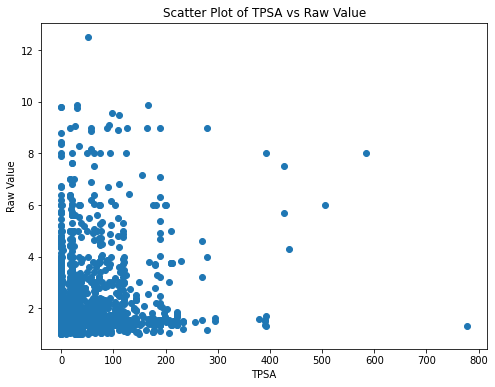

In [49]:
fig, ax = plt.subplots(figsize=(8,6))
ax.scatter(df_wmw['tpsa'], df_wmw['raw_value'])
ax.set_xlabel('TPSA')
ax.set_ylabel('Raw Value')
ax.set_title('Scatter Plot of TPSA vs Raw Value')
plt.show()

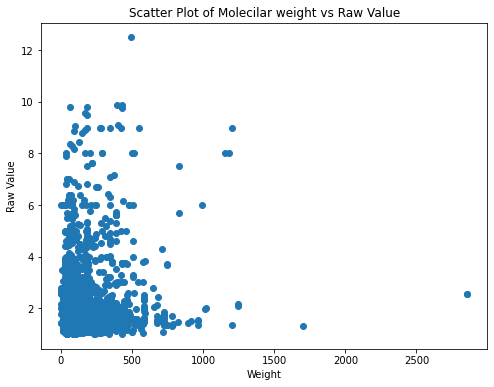

In [50]:
fig, ax = plt.subplots(figsize=(8,6))
ax.scatter(df_wmw['molecular_weight'], df_wmw['raw_value'])
ax.set_xlabel('Weight')
ax.set_ylabel('Raw Value')
ax.set_title('Scatter Plot of Molecilar weight vs Raw Value')
plt.show()

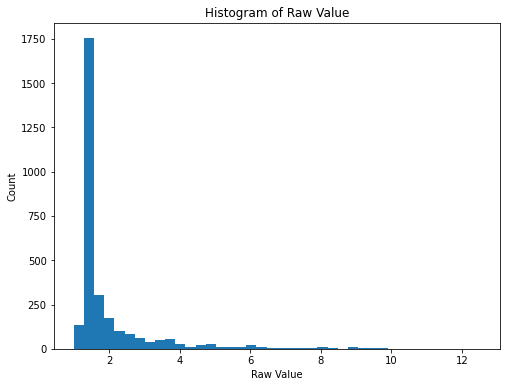

In [55]:
fig, ax = plt.subplots(figsize=(8,6))
ax.hist(df_wmw['raw_value'], bins=40)
ax.set_xlabel('Raw Value')
ax.set_ylabel('Count')
ax.set_title('Histogram of Raw Value')
plt.show()

In [59]:
#let's find the outliers using IQR method
Q1 = df_wmw['raw_value'].quantile(0.25)
Q3 = df_wmw['raw_value'].quantile(0.75)
IQR = Q3 - Q1
lower_range = Q1 - (1.5 * IQR)
upper_range = Q3 + (1.5 * IQR)

outliers = df_wmw[(df_wmw['raw_value'] < lower_range) | (df_wmw['raw_value'] > upper_range)]

print(len(outliers))

420


In [60]:
print(df_wmw.shape) #For now we have 2941 samples out of initial 5000

(2941, 2050)


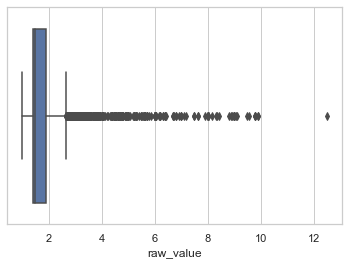

In [58]:
sns.set(style="whitegrid")
sns.boxplot(x=df_wmw['raw_value'])
plt.show()

In [ ]:
df_ex = pd.read_csv('df_clean.tsv', sep='\t')

C:\Users\bocha\AppData\Local\Temp\ipykernel_12824\3115337417.py:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df_wmw['raw_value'], shade=True)


KeyError: 'z_score'

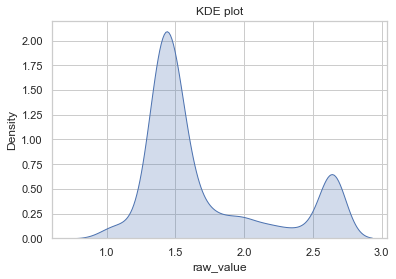

In [69]:
# Create a KDE plot
sns.kdeplot(df_wmw['raw_value'], shade=True)

# Add title and axis labels
plt.title("KDE plot")
plt.xlabel("raw_value")
plt.ylabel("Density")

# Add red lines to show the outliers
outlier_values = df_wmw[df_wmw['z_score'] > threshold]['raw_value'].values
for value in outlier_values:
    plt.axvline(x=value, color='r')

# Show the plot
plt.show()

### Outliers capping

In some cases, it may be appropriate to remove outliers from the dataset. However, in many cases, it is better to cap the outliers by replacing them with the corresponding upper or lower limit, as removing them can result in loss of information and bias in the analysis.

Capping the outliers means that the data will still be retained, but any extreme values that could potentially skew the analysis will be brought back into the range of the rest of the data. This can help to ensure that statistical analyses are more accurate and reliable.

In [61]:
df_wmw.loc[df_wmw['raw_value'] < lower_range, 'raw_value'] = lower_range
df_wmw.loc[df_wmw['raw_value'] > upper_range, 'raw_value'] = upper_range

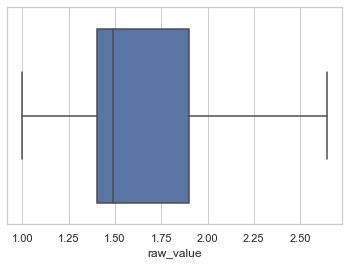

In [62]:
sns.set(style="whitegrid")
sns.boxplot(x=df_wmw['raw_value'])
plt.show()

Now our value distribution looks much better, no outliers

In [66]:
df_wmw.to_csv('df_cap.tsv', sep='\t', index=False)

## Data transformation

Let's explore what are the types of values we have in our columns

In [63]:
pd.set_option('display.max_rows', None)
print(df_wmw.dtypes)

DOI                          object
Date                         object
Journal                      object
Title                        object
Name                         object
measurement_error           float64
measurement_method           object
isomeric_smiles              object
raw_value                   float64
specifier                    object
cid                          object
MaxEStateIndex              float64
MinEStateIndex              float64
MaxAbsEStateIndex           float64
MinAbsEStateIndex           float64
qed                         float64
MolWt                       float64
HeavyAtomMolWt              float64
ExactMolWt                  float64
NumValenceElectrons         float64
NumRadicalElectrons         float64
MaxPartialCharge            float64
MinPartialCharge            float64
MaxAbsPartialCharge         float64
MinAbsPartialCharge         float64
FpDensityMorgan1            float64
FpDensityMorgan2            float64
FpDensityMorgan3            

In [ ]:
df = pd.read_csv('df_cap.tsv', sep='\t')

In [71]:
df.head()

DOI        Date  \
0  10.1016/j.optlaseng.2008.09.005   1/14/2009   
1       10.1016/j.jiec.2018.12.038  12/29/2018   
2     10.1016/j.jlumin.2015.02.010   2/14/2015   
3                 10.1039/B717069F    3/7/2023   
4      10.1529/biophysj.106.094946  10/23/2008   

                                           Journal  \
0                 Optics and Lasers in Engineering   
1  Journal of Industrial and Engineering Chemistry   
2                          Journal of Luminescence   
3                                  J. Mater. Chem.   
4                              Biophysical Journal   

                                               Title        Name  \
0  A high-precision measurement technique for eva...     Alcohol   
1  Improving understanding of solvent effects on ...  aceticacid   
2  Spectroscopic properties of tellurite glasses ...   Phosphate   
3  High refractive index polyimide–nanocrystallin...         BK7   
4  Quantitative Characterization of Biological Li...     ethanol   

   measurement_error measurement_method  \
0            0.00000         el_mylogic   
1            0.00000         el_mylogic   
2            0.00000         el_mylogic   
3            0.00000           snowball   
4            0.00126        el_cde_text   

                                     isomeric_smiles  raw_value  \
0                                                CCO    1.34749   
1                                            CC(O)=O    1.70000   
2                              [O-][P]([O-])([O-])=O    1.54000   
3  CCOC1=CC2=C(C=C1)C=C(C=C2)C3=NN(C4=NC=NC(=C34)...    1.51800   
4                                                CCO    1.35434   

                    specifier         cid  MaxEStateIndex  MinEStateIndex  \
0        Refractive index (n)       702.0        7.569444        0.250000   
1                           n       176.0        9.000000       -0.833333   
2  Refractive index (~600 nm)      1061.0        8.548611       -5.388889   
3            refractive index  53346432.0        6.275722        0.470696   
4            refractive index       702.0        7.569444        0.250000   

   MaxAbsEStateIndex  MinAbsEStateIndex       qed    MolWt  HeavyAtomMolWt  \
0           7.569444           0.250000  0.406808   46.069          40.021   
1           9.000000           0.833333  0.429883   60.052          56.020   
2           8.548611           5.388889  0.303344   94.970          94.970   
3           6.275722           0.470696  0.529743  402.502         376.294   
4           7.569444           0.250000  0.406808   46.069          40.021   

   ExactMolWt  NumValenceElectrons  NumRadicalElectrons  MaxPartialCharge  \
0   46.041865                 20.0                  0.0          0.040221   
1   60.021129                 24.0                  0.0          0.299685   
2   94.955066                 32.0                  0.0         -0.158702   
3  402.216809                154.0                  0.0          0.163476   
4   46.041865                 20.0                  0.0          0.040221   

   MinPartialCharge  MaxAbsPartialCharge  MinAbsPartialCharge  \
0         -0.396664             0.396664             0.040221   
1         -0.481433             0.481433             0.299685   
2         -0.822417             0.822417             0.158702   
3         -0.493867             0.493867             0.163476   
4         -0.396664             0.396664             0.040221   

   FpDensityMorgan1  FpDensityMorgan2  FpDensityMorgan3  BCUT2D_MWHI  \
0               2.0               2.0          2.000000    16.248991   
1               2.0               2.0          2.000000    16.363929   
2               1.2               1.2          1.200000    31.204228   
3               1.1               1.9          2.733333    16.476061   
4               2.0               2.0          2.000000    16.248991   

   BCUT2D_MWLOW  BCUT2D_CHGHI  BCUT2D_CHGLO  BCUT2D_LOGPHI  BCUT2D_LOGPLOW  \
0     10.908168      1.340294     -1.

We have to decide on transformation method for columns 'measurement_method', 'isomeric_smiles', 'specifier'.

It seems like measurement methods are repeating, there are a finite number of methods, so i believe Label Encoding or Ordinal Encoding would be a perfect choise for it.

In [72]:
unique_values = df['measurement_method'].unique()
print(unique_values)

['el_mylogic' 'snowball' 'el_cde_text' 'rsc_mylogic' 'el_cde_tables'
 'rsc_cde_text' 'rsc_cde_tables' 'springer_cde_table' 'springer_cde_text']


In [73]:
ordinal_mapping = {'el_mylogic': 1, 'snowball': 2, 'el_cde_text': 3, 'rsc_mylogic': 4, 'el_cde_tables': 5,
 'rsc_cde_text': 6, 'rsc_cde_tables': 7, 'springer_cde_table': 8, 'springer_cde_text': 9}

df['measurement_method_encoded'] = df['measurement_method'].map(ordinal_mapping)

In [75]:
#i forgot to move the encoded column to the initial column, let's fix it
measurement_method_idx = df.columns.get_loc('measurement_method')
measurement_method_encoded_idx = df.columns.get_loc('measurement_method_encoded')
cols = list(df.columns)
cols.pop(measurement_method_encoded_idx)
cols.insert(measurement_method_idx + 1, 'measurement_method_encoded')
df = df.loc[:, cols]

For the 'isomeric_smiles' the situation is different, there is a big number of different smiles, let's prove it just in case

In [78]:
unique_values = df['isomeric_smiles'].unique()
print(unique_values)
len(unique_values)

['CCO' 'CC(O)=O' '[O-][P]([O-])([O-])=O' ...
 'CCCCCCCCCCOCCOCCOCCOCCOCCOCCOCCOCCO' 'CC(C)CCCCCCCO'
 'c1ccc(cc1)c2ccccc2']


1182

...oh dear Lord...

Count encoding or frequency encoding may be more appropriate. **Count encoding** would replace each unique smile with the number of times it appears in the dataset. This would reduce the number of unique values in the column, which could make it easier for machine learning algorithms to work with. **Frequency encoding** would replace each unique smile with its frequency in the dataset, which could be informative if the frequency of each smile is correlated with the target variable.

I looks like Frequency encoding can give us more information on possible correlation between target value and it, so i would use it.

In [80]:
freq_encode = df['isomeric_smiles'].value_counts(normalize=True)
df['isomeric_smiles_freq_encoded'] = df['isomeric_smiles'].map(freq_encode)
# moving next to initial column
if 'isomeric_smiles_freq_encoded' in df:
    df = df.drop('isomeric_smiles_freq_encoded', axis=1)

df.insert(loc=df.columns.get_loc('isomeric_smiles')+1, column='isomeric_smiles_freq_encoded', value=df['isomeric_smiles'].map(freq_encode))

Let's check specifier next

In [82]:
unique_values = df['specifier'].unique()
print(unique_values)
len(unique_values)

['Refractive index (n)' 'n' 'Refractive index (~600 nm)'
 'refractive index' 'Ref. index' 'Index of refraction'
 'refractive index n' 'nD' 'Refraction index' 'Refractive index' 'ri'
 'refraction indices' 'RI' 'Refractive index (nD)' 'Refractive (nD)'
 'Refractive index, nd (589.3\u202fnm)' 'RI to 300 ppm H2' 'R.I.' 'R.I'
 'Refractive index (633 nm)' 'Refractive index at 98.9\xa0°C'
 'Refractive index nd' 'Refractive indices' 'Refractive Index'
 'Refractive index, nD20' 'Refractive index\xa0(n)'
 'Reflective Index (RI)' 'Refractive index, no'
 'Refractive index, nd (±0.001)' 'Refractive index, n'
 'Optimal refractive index' 'Refractive index (ni)'
 'Refractive index at 20°C' 'Refractive index post-humidity exposureb,10'
 'RI at 20 °C est. LNB' 'Refractive index (n12)' 'RI to 500 ppm CO'
 'refractive indices' 'index of refraction' 'Refractive index nD'
 'Core refractive index' 'Cladding refractive index'
 'Refractive index at 8 μm' 'Refractive index, nd' 'Refractive index n'
 'Measured r

236

Wow, this column is a mess...

Let's also apply Frequency encoding

In [83]:
freq_encode = df['specifier'].value_counts(normalize=True)
df['specifier_freq_encoded'] = df['specifier'].map(freq_encode)
# moving next to initial column
if 'specifier_freq_encoded' in df:
    df = df.drop('specifier_freq_encoded', axis=1)

df.insert(loc=df.columns.get_loc('specifier')+1, column='specifier_freq_encoded', value=df['specifier'].map(freq_encode))

In [84]:
df.to_csv('df_trans.tsv', sep='\t', index=False)

## Data normalization

In [87]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Get a list of columns with numeric data types
numeric_columns = df.select_dtypes(include=[np.number]).columns.tolist()

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Drop columns with infinite or very large values
for column in numeric_columns:
    if np.any(np.isinf(df[column].values)) or np.max(df[column].values) > 1e20:
        print(f"Dropping column '{column}' due to infinite or very large values")
        df.drop(column, axis=1, inplace=True)
    else:
        df[column] = scaler.fit_transform(df[[column]])

# Convert the normalized data back to a pandas DataFrame
df_normalized = pd.DataFrame(df, columns=df.columns)

Dropping column 'MaxPartialCharge' due to infinite or very large values
Dropping column 'MaxAbsPartialCharge' due to infinite or very large values


And the resulting df is:

In [94]:
df_normalized.head()

DOI        Date  \
0  10.1016/j.optlaseng.2008.09.005   1/14/2009   
1       10.1016/j.jiec.2018.12.038  12/29/2018   
2     10.1016/j.jlumin.2015.02.010   2/14/2015   
3                 10.1039/B717069F    3/7/2023   
4      10.1529/biophysj.106.094946  10/23/2008   

                                           Journal  \
0                 Optics and Lasers in Engineering   
1  Journal of Industrial and Engineering Chemistry   
2                          Journal of Luminescence   
3                                  J. Mater. Chem.   
4                              Biophysical Journal   

                                               Title        Name  \
0  A high-precision measurement technique for eva...     Alcohol   
1  Improving understanding of solvent effects on ...  aceticacid   
2  Spectroscopic properties of tellurite glasses ...   Phosphate   
3  High refractive index polyimide–nanocrystallin...         BK7   
4  Quantitative Characterization of Biological Li...     ethanol   

   measurement_error measurement_method  measurement_method_encoded  \
0           0.000000         el_mylogic                       0.000   
1           0.000000         el_mylogic                       0.000   
2           0.000000         el_mylogic                       0.000   
3           0.000000           snowball                       0.125   
4           0.000191        el_cde_text                       0.250   

                                     isomeric_smiles  \
0                                                CCO   
1                                            CC(O)=O   
2                              [O-][P]([O-])([O-])=O   
3  CCOC1=CC2=C(C=C1)C=C(C=C2)C3=NN(C4=NC=NC(=C34)...   
4                                                CCO   

   isomeric_smiles_freq_encoded  raw_value                   specifier  \
0                      0.822222   0.211218        Refractive index (n)   
1                      0.077778   0.425656                           n   
2                      0.066667   0.328325  Refractive index (~600 nm)   
3                      0.044444   0.314942            refractive index   
4                      0.822222   0.215385            refractive index   

   specifier_freq_encoded       cid  MaxEStateIndex  MinEStateIndex  \
0                0.030622  0.000004        0.495640        0.536622   
1                1.000000  0.000001        0.589311        0.471849   
2                0.000957  0.000006        0.559755        0.199469   
3                0.286124  0.329198        0.410928        0.549817   
4                0.286124  0.000004        0.495640        0.536622   

   MaxAbsEStateIndex  MinAbsEStateIndex       qed     MolWt  HeavyAtomMolWt  \
0           0.495640           0.031250  0.419109  0.015784        0.014014   
1           0.589311           0.104167  0.444098  0.020682        0.019616   
2           0.559755           0.673611  0.307064  0.032913        0.033255   
3           0.410928           0.058837  0.552241  0.140637        0.131764   
4           0.495640           0.031250  0.419109  0.015784        0.014014   

   ExactMolWt  NumValenceElectrons  NumRadicalElectrons  MinPartialCharge  \
0    0.015776             0.031646                  0.0          0.371905   
1    0.020673             0.037975                  0.0          0.359795   
2    0.032910             0.050633                  0.0          0.311083   
3    0.140547             0.243671                  0.0          0.358019   
4    0.015776             0.031646                  0.0          0.371905   

   MinAbsPartialCharge  FpDensityMorgan1  FpDensityMorgan2  FpDensityMorgan3  \
0             0.010055             0.500             0.500          0.500000   
1             0.074921             0.500             0.500          0.500000   
2             0.039676             0.300             0.300          0.300000   
3             0.040869             0.275             0.475          0.683333   
4             0.010055

In [95]:
print(df_normalized.shape)

(2941, 2051)


In [96]:
df_normalized.to_csv('df_normalized.tsv', sep='\t', index=False)